In [1]:
import nilearn.image, nilearn.decoding

import numpy as np
import pandas as pd

#from sklearn.svm import LinearSVC
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LinearRegression

In [2]:
#!pushd \\10.201.185.39\clmnlab

In [3]:
TM_dir = '/clmnlab/TM'
#TM_dir = 'Z:/TM'
#TM_dir = 'E:/data'

behav_dir = TM_dir + '/behav_data/'
fan_roi_dir = TM_dir + '/fMRI_data/masks/Fan/Fan280/'
stats_dir_5 = TM_dir + '/fMRI_data/stats/Reg5_MVPA1_IM_vibration/'
stats_dir_6 = TM_dir + '/fMRI_data/stats/Reg6_MVPA2_IM_VWM/'
stats_dir_7 = TM_dir + '/fMRI_data/stats/Reg7_MVPA3_IM_COY/'
stats_dir_9 = TM_dir + '/fMRI_data/stats/Reg9_MVPA4_IM_vibration/'
stats_dir_10 = TM_dir + '/fMRI_data/stats/Reg10_*/'
stats_dir_11 = TM_dir + '/fMRI_data/stats/Reg11_*/'
stats_dir_12 = TM_dir + '/fMRI_data/stats/Reg12_*/'
preproc_dir = TM_dir + '/fMRI_data/preproc_data/'

subj_list = ["TML04_PILOT","TML05_PILOT","TML06_PILOT","TML07_PILOT", 
            "TML08_PILOT","TML09_PILOT","TML10_PILOT","TML11_PILOT",
            "TML12_PILOT","TML13","TML14","TML15","TML16","TML18","TML19","TML20",
            "TML21","TML22","TML23","TML24","TML25","TML26","TML28","TML29"]
freq_range = range(10,20+1,1)
freq_c = freq_range[5]

### Local Definitions

In [4]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    #print(freqs)
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)

In [5]:
def get_dataframe(subj, run):
    df = pd.read_csv(behav_dir + subj + '/behav_data_Dis.dat', sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
    df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
    df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
    df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
    df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
    df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.rank'] = [a+b for a, b in zip(df['Freq.1.rank'], df['Freq.2.rank'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['F1<F2.rank'] = [b-a for a, b in zip(df['Freq.1'], df['Freq.2'])]

    temp = []
    trials = [40, 30, 30]
    fin = 0
    for x in trials:
        ini = fin
        fin = ini + x
        temp.append(df.loc[ini:fin-1])

    ## Note, Freq.other_answer.class == Freq.other_updown.class
    #validation = df['Freq.other_answer.class'] == df['Freq.other.classifier']
    #assert validation.all() == True
    #assert df['Freq.other_decision.class'].shape[0] == sum(trials)
    assert len(temp[run-1]) == trials[run-1]

    return temp[run-1]

In [6]:
def load_beta_image(subj, run, nbetas=6, target_idx=2):
## load nilearn image ##
    img = nilearn.image.load_img(stats_dir_12 + '%s/r%02d.LSSout.nii.gz' % (subj, run))
    
    df = get_dataframe(subj, run)
    ntrials = len(df.index)
    idx = np.array([ nbetas*i + target_idx for i in range(ntrials) ])
    
    temp = nilearn.image.index_img(img, idx)

    return temp

In [7]:
def load_target(subj, run):
## load behavior data and make up them ##
    df = get_dataframe(subj, run)
    classifier = list(df['F1<F2.rank'])

    return classifier

In [8]:
### X: neural data / y: answers / group: run number
def get_X_y_group(subj, runs):      

    Xs = [ load_beta_image(subj, run) for run in runs ]
    ys = [ load_target(subj, run) for run in runs ]
    group = [ i for i, y in enumerate(ys) for j in range(len(y)) ]
    
    Xs = nilearn.image.concat_imgs(Xs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    return Xs, np.int32(ys), np.array(group)

In [9]:
def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)

    if img_data.shape[:3] != roi_mask.shape:
        if roi_mask.shape[-1] == 1:
            volume = roi_mask.shape[:3]
            roi_mask = roi_mask.reshape(volume)
        else:
            raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))

    return img_data[roi_mask,:]

In [10]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

In [11]:
from sklearn.preprocessing import scale

def mean_centering(fast_masking_Xs):
    ## mean-centerning #1 (not normalize)
    a = fast_masking_Xs
#     ## run 01
#     t = np.mean(a[:,:40],axis=1)
#     t = np.tile(t,(40,1)).T
#     a[:,:40] = a[:,:40] - t
#     ## run 02
#     t = np.mean(a[:,40:70],axis=1)
#     t = np.tile(t,(30,1)).T
#     a[:,40:70] = a[:,40:70] - t
#     ## run 03
#     t = np.mean(a[:,70:100],axis=1)
#     t = np.tile(t,(30,1)).T
#     a[:,70:100] = a[:,70:100] - t
    
    ## mean-centerning #1 (normalize)
    a[:,:40] = scale(a[:,:40],axis=1)
    a[:,40:70] = scale(a[:,40:70],axis=1)
    a[:,70:100] = scale(a[:,70:100],axis=1)
    return a

In [12]:
from scipy import special
from scipy import optimize

def psychometric_x_y(subj):
    df = pd.concat([get_dataframe(subj, 1),get_dataframe(subj, 2),get_dataframe(subj, 3)])
    a = df['Freq.other.rank']
    x = np.unique(df['Freq.other.rank'])
    c = df['Freq.other_decision.class'] # 'NaN' can be existed
    #prob = [len(a[(c==1)&(a==x[i])])*0.1 for i in range(10)]
    prob = [len(a[(c==1)&(a==x[i])])/len(a[a==x[i]]) for i in range(10)]
    return x, prob

def test_func(x, s):
    return 0.5*(1+special.erf(x/(np.sqrt(2)*s)))

In [13]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import scale
from PCRegression import PCR
import scipy.stats as stats
import matplotlib.pyplot as plt
from nilearn import plotting as nplt
from random import random as rand
from random import seed

def myPCR(subj, path_roi):
    #np.set_printoptions(formatter={'float': '{: 0.5e}'.format})
    Xs, ys, group = get_X_y_group(subj, [1,2,3])

    ## whole brain
    #path_full = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
    ## Ttest mask
    #path_tt10 = stats_dir_10 + subj + '/Clust_mask_binary.nii.gz' 
    ## Ttest mask
    #path_tt11 = stats_dir_11 + subj + '/Clust_mask_binary.nii.gz'

    roi = nilearn.image.load_img(path_roi)
    
    temp = fast_masking(img=Xs, roi=roi)
    k = len(np.unique(group))
    cv = GroupKFold(k)
    nvoxels = temp.shape[0]
    #temp = mean_centering(temp)
    XT = temp.T
    print("%s's XT.shape ="%subj, XT.shape)
    
    nPCs = list(range(10,60,5))
    nPCs.append(None)
    #nPCs = [str(i) for i in nPCs]

    rval, pval = np.zeros(len(nPCs)), np.zeros(len(nPCs))
    ypred_opt = np.zeros(100)
    dg = pd.DataFrame(index=[subj], columns=nPCs)
    for i, n in enumerate(nPCs):
        ypred = np.zeros(100)
        for idx_train, idx_test in cv.split(XT, ys, group):
            g = int(np.unique(group[idx_test]))
            Xtrain = XT[idx_train,:]
            ytrain = ys[idx_train]
            #seed()
#             pcr = PCR(n_components = n_components,
#                       svd_solver='arpack',
#                       random_state=int(65536 * rand()))
            pcr = PCR(n_components = n)
            pcr.fit(Xtrain,ytrain)
            Xtest = XT[idx_test,:]
            ypred[idx_test] = pcr.predict(Xtest)
        rval[i], pval[i] = stats.pearsonr(ys,ypred)
        dg[n] = [ypred]
        if n==np.argmax(rval):
            ypred_opt = ypred
            
    idx_opt, rval_best = np.argmax(rval), np.max(rval)
    df = pd.DataFrame(
        {
            'nPCs_best':nPCs[idx_opt],
            'rval_best':rval_best,
            'nvoxels':nvoxels,
            'rval':[rval]
        },
        index=[subj]
    )
    colhead = ['nPCs_best','rval_best','nvoxels','rval']
    df = df.reindex(columns=colhead)
    
    return df, dg

### Fan Masks Labeling

In [14]:
import glob

label_data = TM_dir + '/fMRI_data/masks/Fan/Fan280/fan280_fullname.csv'
fan_roi = pd.read_csv(label_data, header=None)
fan_roi = fan_roi.rename(columns={0: 'label'})

fan_roi_path = sorted(glob.glob(fan_roi_dir + 'fan.roi.resam.*.nii.gz'))
fan_roi_imgs = np.array([nilearn.image.load_img(path) for path in fan_roi_path])
len_roi = fan_roi.shape[0]

for i in range(len(fan_roi_path)):
    row = int(fan_roi_path[i][-10:-7])-1
    #fan_roi.loc[row,'imgs'] = fan_roi_imgs[i]
    fan_roi.loc[row,'nvoxels'] = np.sum(fan_roi_imgs[i].get_fdata()>0,axis=None)

In [15]:
from nilearn import plotting as nplt

num_fan = 65

## fan masks
path_fan = fan_roi_dir + 'fan.roi.resam.%03d.nii.gz' %(num_fan+1)
title_fan = fan_roi.loc[num_fan,'label']

fan_roi.loc[num_fan-5:num_fan+5,['label','nvoxels']]

label  nvoxels
60     Lt. precentral gyrus (BA4, tongue and larynx)    432.0
61     Rt. precentral gyrus (BA4, tongue and larynx)    403.0
62  Lt. precentral gyrus (BA6, caudal ventrolateral)    742.0
63  Rt. precentral gyrus (BA6, caudal ventrolateral)    641.0
64      Lt. paracentral lobule (BA1/2/3, lower limb)    344.0
65      Rt. paracentral lobule (BA1/2/3, lower limb)    442.0
66          Lt. paracentral lobule (BA4, lower limb)    465.0
67          Rt. paracentral lobule (BA4, lower limb)    586.0
68        Lt. superior temporal gyrus (BA38, medial)    692.0
69        Rt. superior temporal gyrus (BA38, medial)    640.0
70             Lt. superior temporal gyrus (BA41/42)    482.0

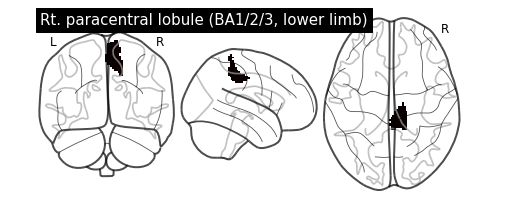

In [16]:
roi = nilearn.image.load_img(path_fan)
nplt.plot_glass_brain(roi,title=title_fan)

# Test

### Load the subject's data

In [17]:
subj = 'TML10_PILOT'
Xs, ys, group = get_X_y_group(subj, [1,2,3])

### Compare t-test masks

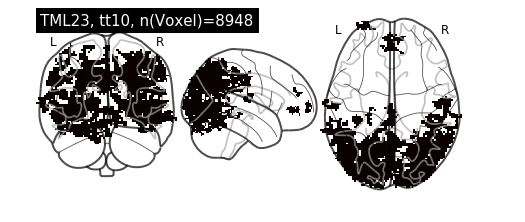

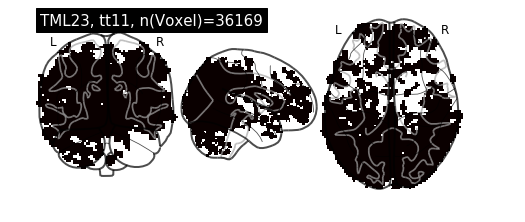

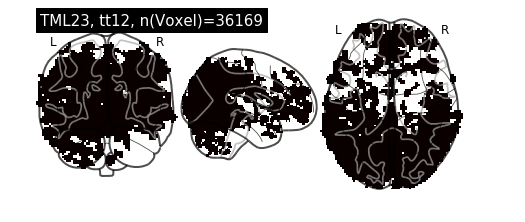

In [18]:
from nilearn import plotting as nplt

subj = 'TML23'

## whole brain
path_full = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
title_full = 'full_mask.%s.nii.gz' %subj

## Ttest mask
path_tt10 = stats_dir_10 + subj + '/Clust_mask_binary.nii.gz'
roi = nilearn.image.load_img(path_tt10)
temp = roi.get_fdata()
nplt.plot_glass_brain(roi,title='%s, tt10, n(Voxel)=%d'%(subj,len(temp[temp>0])))

## Ttest mask
path_tt11 = stats_dir_11 + subj + '/Clust_mask_binary.nii.gz'
roi = nilearn.image.load_img(path_tt11)
temp = roi.get_fdata()
nplt.plot_glass_brain(roi,title='%s, tt11, n(Voxel)=%d'%(subj,len(temp[temp>0])))

## Ttest mask
path_tt12 = stats_dir_12 + subj + '/Clust_mask_binary.nii.gz'
roi = nilearn.image.load_img(path_tt11)
temp = roi.get_fdata()
nplt.plot_glass_brain(roi,title='%s, tt12, n(Voxel)=%d'%(subj,len(temp[temp>0])))

## Voxel Analysis

In [19]:
from sklearn.preprocessing import scale

roi = nilearn.image.load_img(path_full)
Xs_val = fast_masking(img=Xs, roi=roi)

## mean-centerning(not normalize)
#Xs_val = mean_centering(Xs_val)

nvoxels = Xs_val.shape[0]
Xs_val.shape

(279973, 100)

### Check Collinearity on each voxel

In [38]:
# for i in range(nvoxels):
#     print('voxel# =', i, ':', pd.Series(Xs_val[i,:]).autocorr())

### Covariant matrix

### betas

In [20]:
idx_p = np.concatenate(np.where(ys>0))
idx_m = np.concatenate(np.where(ys<0))
print(len(idx_p),len(idx_m))

50 50


In [21]:
from random import sample

## univoxel
voxel = sample(range(Xs_val.shape[0]),1)[0]
print('random voxel# =',voxel)
print(Xs_val[voxel],':',Xs_val[voxel].shape)
betas_p = Xs_val[voxel,idx_p]
betas_m = Xs_val[voxel,idx_m]

## multivoxel(voxel mean)
# betas_p = np.mean(Xs_val[:,idx_p],axis=0)
# betas_m = np.mean(Xs_val[:,idx_m],axis=0)

random voxel# = 138984
[ 0.51179683 -0.77053487  0.48995125 -0.21861821 -1.20998669 -0.46370625
 -1.67275977 -0.2650578   0.11619186 -0.12622547 -0.51896405 -0.35956645
  1.34063661 -0.16721235 -0.06379059 -1.1555779  -0.95382082  0.31287169
 -0.1897645  -1.44592524  0.27054071 -0.95629859 -0.30752945 -1.74170816
 -0.35565138 -0.38018179 -0.74955869 -0.29045057  0.03958225 -0.36078143
 -1.0218358   0.33324862  0.57873166 -0.69706023 -1.12014401 -0.99816334
  0.49252796 -0.38537908  0.48827267 -0.53728771 -0.31715012  0.07297832
 -0.89140981 -1.54641938  1.54162073 -0.96038091 -0.56894064 -0.08194824
  0.00366855 -0.03587687  0.06536734  1.48467207 -0.83281136 -1.55317688
 -0.53195351 -0.67738497  0.52428687 -1.73228216 -0.51907134 -0.84598351
 -1.31621432 -0.31466675  0.49855304  0.52847469 -0.78026533 -0.98483205
 -0.58200312 -1.04958487  0.05228376 -1.56224251 -0.88455427  0.18088402
  0.2352708  -1.73395228  0.6296618   1.38370192  0.9964571  -0.84058714
 -1.66907728  0.82755047 -0.

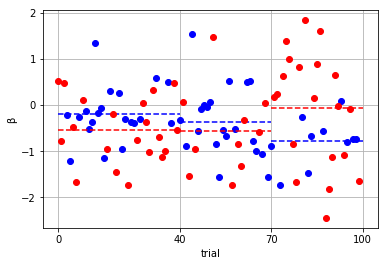

In [22]:
import matplotlib.pyplot as plt

plt.plot(idx_p, betas_p, 'bo')
#plt.axhline(y=np.mean(betas_p), color='b', linestyle='--')
mu = np.mean(betas_p[idx_p<40])
plt.plot([0,40],[mu,mu], color='b', linestyle='--')
mu = np.mean(betas_p[(40<=idx_p)&(idx_p<70)])
plt.plot([40,70],[mu,mu], color='b', linestyle='--')
mu = np.mean(betas_p[(70<=idx_p)&(idx_p<100)])
plt.plot([70,100],[mu,mu], color='b', linestyle='--')

plt.plot(idx_m, betas_m, 'ro')
#plt.axhline(y=np.mean(betas_m), color='r', linestyle='--')
mu = np.mean(betas_m[idx_p<40])
plt.plot([0,40],[mu,mu], color='r', linestyle='--')
mu = np.mean(betas_m[(40<=idx_m)&(idx_m<70)])
plt.plot([40,70],[mu,mu], color='r', linestyle='--')
mu = np.mean(betas_m[(70<=idx_m)&(idx_m<100)])
plt.plot([70,100],[mu,mu], color='r', linestyle='--')

plt.grid()
plt.xticks([0,40,70,100])
plt.xlabel('trial')
plt.ylabel('\u03B2')
plt.show()

### Boxplots

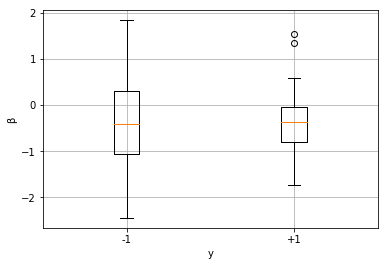

In [23]:
plt.boxplot([betas_m,betas_p],labels=['-1','+1'])
plt.grid()
plt.xlabel('y')
plt.ylabel('\u03B2')
plt.show()

In [24]:
df = pd.DataFrame(index=range(100), columns=[-5,-4,-3,-2,-1,1,2,3,4,5])
for t in range(100):
    df.loc[t,ys[t]] = np.mean(Xs_val[:,t],axis=0)
df    

-5         -4        -3          -2         -1         1  \
0         NaN   0.156885       NaN         NaN        NaN       NaN   
1  -0.0141083        NaN       NaN         NaN        NaN       NaN   
2         NaN        NaN       NaN    0.176126        NaN       NaN   
3         NaN        NaN       NaN         NaN        NaN -0.036815   
4         NaN        NaN       NaN         NaN        NaN       NaN   
5  -0.0262589        NaN       NaN         NaN        NaN       NaN   
6         NaN        NaN       NaN   -0.067114        NaN       NaN   
7         NaN        NaN       NaN         NaN        NaN       NaN   
8         NaN        NaN       NaN         NaN   -0.04123       NaN   
9         NaN        NaN       NaN         NaN        NaN       NaN   
10        NaN        NaN       NaN         NaN        NaN       NaN   
11        NaN        NaN       NaN         NaN        NaN       NaN   
12        NaN        NaN       NaN         NaN        NaN       NaN   
13        NaN        NaN       NaN         NaN        NaN       NaN   
14        NaN        NaN       NaN         NaN        NaN -0.101264   
15        NaN        NaN       NaN         NaN        NaN       NaN   
16        NaN    -0.1052       NaN         NaN        NaN       NaN   
17        NaN        NaN       NaN         NaN        NaN       NaN   
18        NaN        NaN       NaN         NaN  0.0253681       NaN   
19   0.107609        NaN       NaN         NaN        NaN       NaN   
20        NaN        NaN       NaN         NaN        NaN   0.06949   
21        NaN        NaN       NaN         NaN        NaN       NaN   
22        NaN        NaN       NaN         NaN        NaN       NaN   
23        NaN  -0.214843       NaN         NaN        NaN       NaN   
24        NaN        NaN       NaN         NaN        NaN       NaN   
25        NaN        NaN       NaN         NaN        NaN       NaN   
26        NaN        NaN       NaN         NaN   0.107456       NaN   
27        NaN        NaN       NaN         NaN        NaN       NaN   
28        NaN        NaN  0.108292         NaN        NaN       NaN   
29        NaN        NaN       NaN    0.210594        NaN       NaN   
..        ...        ...       ...         ...        ...       ...   
70        NaN        NaN       NaN         NaN        NaN       NaN   
71        NaN        NaN  0.222511         NaN        NaN       NaN   
72   0.224218        NaN       NaN         NaN        NaN       NaN   
73        NaN        NaN       NaN         NaN        NaN       NaN   
74        NaN        NaN       NaN  -0.0673425        NaN       NaN   
75    0.25256        NaN       NaN         NaN        NaN       NaN   
76        NaN        NaN       NaN         NaN   0.224876       NaN   
77        NaN        NaN       NaN         NaN  0.0462313       NaN   
78        NaN -0.0738866       NaN         NaN        NaN       NaN   
79        NaN        NaN  0.159868         NaN        NaN       NaN   
80        NaN        NaN       NaN         NaN        NaN       NaN   
81        NaN   0.454435       NaN         NaN        NaN       NaN   
82        NaN        NaN       NaN         NaN        NaN -0.183543   
83        NaN        NaN       NaN         NaN        NaN       NaN   
84        NaN        NaN  0.286747         NaN        NaN       NaN   
85  0.0118812        NaN       NaN         NaN        NaN       NaN   
86        NaN        NaN       NaN         NaN   0.564698       NaN   
87        NaN        NaN       NaN         NaN        NaN       NaN   
88        NaN        NaN -0.174805         NaN        NaN       NaN   
89        NaN        NaN       NaN -0.00194458        NaN       NaN   
90        NaN  -0.188559       NaN         NaN        NaN       NaN   
91        NaN        NaN  0.115905         NaN        NaN       NaN   
92        NaN   0.087343       NaN         NaN        NaN       NaN   
93        NaN        NaN       NaN         NaN        NaN       NaN   
94  0.0837386        NaN       NaN 

[Text(0, 0.5, 'β'), Text(0.5, 0, 'classifier')]

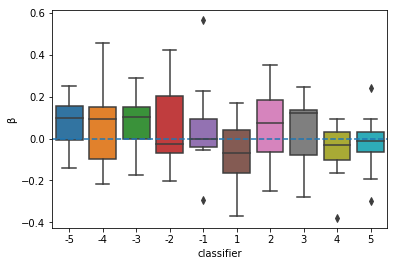

In [25]:
import seaborn as sns

ax = sns.boxplot(data=df)
ax.axhline(0, ls='--')
ax.set(xlabel='classifier', ylabel='\u03B2')

## Psychometric Curve Fitting

### JND of all subjects

In [19]:
#subj_list = ["TML04_PILOT"]
JND = np.ones(len(subj_list)) * np.nan
for i, subj in enumerate(subj_list):
    t, prob = psychometric_x_y(subj)
    params, params_covariance = optimize.curve_fit(test_func, t, prob)
    JND[i] = special.erfinv(0.5)*(np.sqrt(2)*params[0]); # JND for 75%
JND

array([ 1.7728938 ,  1.91514979,  4.28530719, 17.45602441,  1.5640685 ,
        2.36273463,  2.0284352 ,  0.68352339,  1.17190204,  1.17187927,
        1.62216869,  1.09156836,  1.16396224,  1.50281047,  0.83277943,
        0.88439814,  0.9236033 ,  1.81766864,  0.80506208,  2.31191775,
        2.87810533,  1.76188195,  6.39655939,  1.51741243])

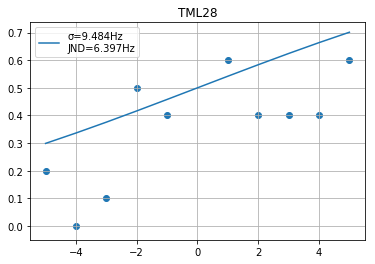

In [19]:
import matplotlib.pyplot as plt

subj = 'TML28'
t, prob = psychometric_x_y(subj)
params, params_covariance = optimize.curve_fit(test_func, t, prob)
JND=special.erfinv(0.5)*(np.sqrt(2)*params[0]); # JND for 75%
plt.scatter(x=t,y=prob)
plt.plot(t, test_func(t, params[0]), label='\u03C3=%.3fHz\nJND=%.3fHz'%(params[0],JND))
plt.legend(loc='best')
plt.title(subj)
plt.grid()

# Principal Component Analysis & Regression

In [95]:
df = pd.DataFrame()
dg = pd.DataFrame()

df, dg = myPCR(subj=subj, path_roi=path_full)

TML29's XT.shape = (100, 272892)


In [97]:
df

nPCs_best  rval_best  nvoxels  \
TML29         55   0.041865   272892   

                                                    rval  
TML29  [-0.20108442742864985, -0.16636540522985344, -...

In [98]:
dg

10  \
TML29  [0.5629640178309192, -0.0364153838722574, -0.0...   

                                                      15  \
TML29  [0.4451030894366197, -0.3341914663375489, -0.0...   

                                                      20  \
TML29  [0.42899218293160885, -0.3399040916858073, 0.0...   

                                                      25  \
TML29  [0.3659080963364286, -0.7146792991706974, 0.06...   

                                                      30  \
TML29  [0.6104690949149842, -0.5477721648670626, -0.0...   

                                                      35  \
TML29  [0.21199474126230797, -0.0018843012143895804, ...   

                                                      40  \
TML29  [0.38450684539261937, 0.0583979097580313, 0.33...   

                                                      45  \
TML29  [0.2659905146410538, -0.21189001769780957, 0.2...   

                                                      50  \
TML29  [0.06287900972759108, -0.031459093826360446, 0...   

                                                      55  \
TML29  [-0.06569568933428023, 0.11997925070861892, 0....   

                                                     NaN  
TML29  [-11503178622.70243, 76634289890.54204, 157700...

### Export to excel

In [19]:
#!pip install xlsxwriter

In [20]:
#import xlsxwriter

df = pd.DataFrame()
dg = pd.DataFrame()
for subj in subj_list:
    path_full = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
    path_tt11 = stats_dir_11 + subj + '/Clust_mask_binary.nii.gz'
    dff, dgg = myPCR(subj, path_roi=path_full)
    df = pd.concat([df,dff])
    dg = pd.concat([dg,dgg])

dh = pd.DataFrame()
ch = df.columns[:2]
dh[ch] = df[ch]
dh['JND'] = JND
ch = df.columns[2:]
dh[ch] = df[ch]
df = dh
#df.to_excel('./temp.xlsx',engine='xlsxwriter')
#dg.to_excel('./temp.xlsx',engine='xlsxwriter')
df.to_csv('./dpcr_whole+noscale.dat',sep='\t')
dg.to_csv('./dypred_whole+noscale.dat',sep='\t')

TML04_PILOT's XT.shape = (100, 272892)
TML05_PILOT's XT.shape = (100, 286902)
TML06_PILOT's XT.shape = (100, 278871)
TML07_PILOT's XT.shape = (100, 280712)
TML08_PILOT's XT.shape = (100, 281191)
TML09_PILOT's XT.shape = (100, 277468)
TML10_PILOT's XT.shape = (100, 255501)
TML11_PILOT's XT.shape = (100, 274775)
TML12_PILOT's XT.shape = (100, 287469)
TML13's XT.shape = (100, 281689)
TML14's XT.shape = (100, 268698)
TML15's XT.shape = (100, 261133)
TML16's XT.shape = (100, 267648)
TML18's XT.shape = (100, 275753)
TML19's XT.shape = (100, 281531)
TML20's XT.shape = (100, 270285)
TML21's XT.shape = (100, 278729)
TML22's XT.shape = (100, 284436)
TML23's XT.shape = (100, 279973)
TML24's XT.shape = (100, 282836)
TML25's XT.shape = (100, 281798)
TML26's XT.shape = (100, 285407)
TML28's XT.shape = (100, 287195)
TML29's XT.shape = (100, 279995)


# Import result & Statistics

In [12]:
#!pip install openpyxl

In [16]:
# import openpyxl

# dpcr_w = pd.read_excel('./PCR.xlsx', index_col=0, engine='openpyxl', sheet_name='whole')
# dpcr_t = pd.read_excel('./PCR.xlsx', index_col=0, engine='openpyxl', sheet_name='tt11')
# dypred_t = pd.read_excel('./ypred.xlsx', index_col=0, engine='openpyxl', sheet_name='tt11')

In [4]:
dpcr_whole = pd.read_csv('./dpcr_whole.dat', sep='\t', index_col=0)
dypred_whole = pd.read_csv('./dypred_whole.dat', sep='\t', index_col=0)
dpcr_whole_noscale = pd.read_csv('./dpcr_whole+noscale.dat', sep='\t', index_col=0)
dypred_whole_noscale = pd.read_csv('./dypred_whole+noscale.dat', sep='\t', index_col=0)
dpcr_tt11 = pd.read_csv('./dpcr_tt11.dat', sep='\t', index_col=0)
dypred_tt11 = pd.read_csv('./dypred_tt11.dat', sep='\t', index_col=0)

### several plots

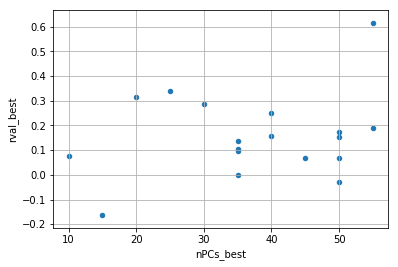

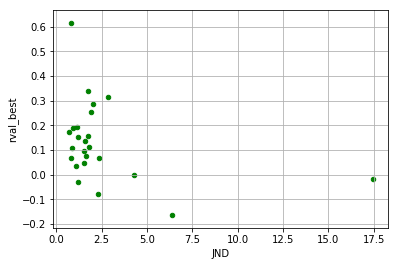

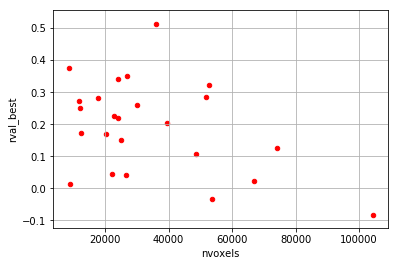

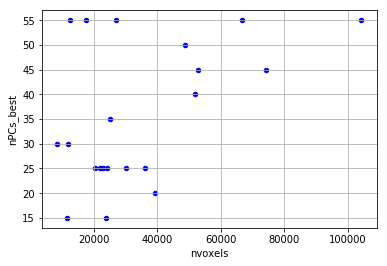

In [16]:
dpcr_whole_noscale.plot.scatter(x='nPCs_best', y='rval_best', grid=True)
dpcr_whole_noscale.plot.scatter(x='JND', y='rval_best', grid=True, color='g')
dpcr_tt11.plot.scatter(x='nvoxels', y='rval_best', grid=True, color='r')
dpcr_tt11.plot.scatter(x='nvoxels', y='nPCs_best', grid=True, color='b')
# dpcr_fan.plot.scatter(x='nPCs_best', y='rval_best', grid=True)
# dpcr_fan.plot.scatter(x='JND', y='rval_best', grid=True, color='g')

## Sort of masks vs rval_best

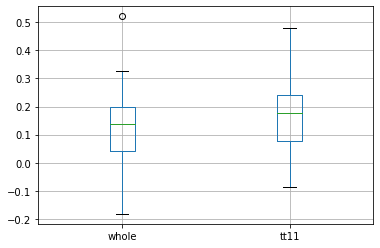

In [7]:
dp = pd.DataFrame({'whole':dpcr_wf.loc[:,'rval_best'],
                   'tt11':dpcr_tf.loc[:,'rval_best']})
dp.boxplot(grid=True)

## rval

### whole brain

In [8]:
import re

nPCs = range(10,60,5)
dk = dpcr_whole
dp = pd.DataFrame(index=dk.index, columns=nPCs)

for idx in dp.index:
    for i, col in enumerate(nPCs):
        temp = re.findall('-0.\d+|0.\d+', dk.loc[idx,'rval'])
        dp.loc[idx,col] = temp[i]
dp

10           15           20           25           30  \
TML04_PILOT   0.23712915   0.19329481   0.21523374   0.24491355   0.25529214   
TML05_PILOT   0.00407868   0.10613374   0.17662945   0.18712105   0.21885917   
TML06_PILOT  -0.26873119  -0.19132908  -0.17360597  -0.16752402   -0.1802848   
TML07_PILOT  -0.10230426  -0.13341861  -0.13615835  -0.15161494  -0.18983439   
TML08_PILOT   0.20247344   0.21430223   0.32861095   0.35633824   0.34214423   
TML09_PILOT  -0.11147439  -0.08911535  -0.07030579  -0.02416932   0.00304565   
TML10_PILOT   0.27762701   0.28274184   0.26479547   0.29497272   0.33843056   
TML11_PILOT   0.07395912   0.15548597    0.2161067   0.17945909   0.22077342   
TML12_PILOT  -0.10043219  -0.03654834  -0.00625585   -0.0083069   0.01553838   
TML13          0.1317126   0.13250788   0.12254964   0.15035034    0.1628321   
TML14         0.12062918   0.14046342   0.12646908   0.11350628   0.11473091   
TML15        -0.02815447   0.01318953   0.05228533   0.08914924   0.12665596   
TML16        -0.01146409    0.0858846   0.07924498   0.18012111    0.1617005   
TML18        -0.03886356  -0.04000666  -0.02677486  -0.03141905  -0.01063217   
TML19        -0.22230046   -0.1033509  -0.10115952  -0.04365438   -0.0391358   
TML20         -0.0183255  -0.01897682   0.07766572   0.09424967   0.12339292   
TML21         0.07699172   0.11634601   0.13413679   0.17643398   0.19182499   
TML22         0.02689228   0.12067673   0.09369423   0.11810006   0.12475322   
TML23         0.53384864   0.54268148   0.53534206   0.53886646   0.53366987   
TML24        -0.23463689  -0.16794278  -0.16140567  -0.16725727  -0.16849203   
TML25         0.19710071   0.27440365   0.27131078   0.27686058   0.25279366   
TML26         0.21236686   0.23297774   0.27569985   0.25989869   0.24325753   
TML28        -0.25187688  -0.18270346  -0.18320585  -0.19828272  -0.19682861   
TML29        -0.16070119    -0.139666  -0.08711422  -0.06303005  -0.06576766   

                      35           40           45           50           55  
TML04_PILOT   0.21424322   0.20524801   0.19502779   0.19103969   0.16857458  
TML05_PILOT   0.23523252   0.21160083   0.21254257   0.21293325   0.23965374  
TML06_PILOT  -0.16813365  -0.18931306  -0.13723217  -0.13250076  -0.08942488  
TML07_PILOT  -0.17164151    -0.215473  -0.16139349  -0.20201478  -0.20204872  
TML08_PILOT   0.35328836   0.35106852    0.3510278   0.35060666   0.33947032  
TML09_PILOT    0.0006853   0.01087264   0.02733607   0.01568719   0.02521331  
TML10_PILOT   0.36996233   0.37187766   0.37860379   0.36993463   0.34370146  
TML11_PILOT   0.21054385   0.18860758   0.20908789   0.19596292   0.22236755  
TML12_PILOT   0.00276339   0.06756115    0.0519267   0.07299703   0.08616398  
TML13         0.15850601   0.16814027   0.16437938   0.19808016   0.14861283  
TML14         0.10112825   0.09486771   0.12859392    0.1516162    0.1602578  
TML15         0.10815247   0.12323495   0.13415437   0.15534255   0.12708592  
TML16         0.16002553   0.18013186   0.16878275    0.2084957   0.19810382  
TML18        -0.00794749  -0.02455895  -0.02947391  -0.00819593  -0.02678466  
TML19        -0.01892392  -0.04582096  -0.05728426   -0.0546266  -0.04542236  
TML20         0.11673282    0.1122903   0.10399587   0.08759143   0.07818872  
TML21         0.18702046   0.21314899   0.19560865   0.19045526   0.19244723  
TML22         0.13105174   0.12258592   0.16909213   0.16957399   0.16686801  
TML23         0.53447661   0.53712336   0.53774781    0.5335235   0.53982113  
TML24        -0.13423895  -0.13791471  -0.11817177  -0.12595164  -0.14340725  
TML25         0.27593889   0.26437348   0.27117834   0.27744897   0.27358083  
TML26         0.23398687   0.23096317   0.23351438   0.21860335    0.1962081  
TML28         -0.1932963  -0.22949001  -0.23157822  -0.21836848  -0.22103287  
TML29         0.03098348   0.02258524    0.0520449   0.06374129   0.08079497

[Text(0, 0.5, 'r'), Text(0.5, 0, 'nPCs')]

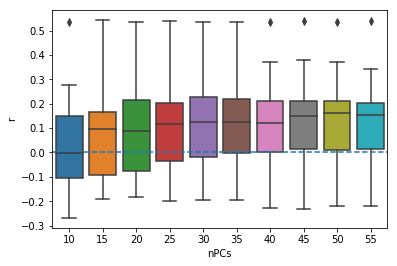

In [9]:
import seaborn as sns

ax = sns.boxplot(data=dp)
ax.axhline(0, ls='--')
ax.set(xlabel='nPCs', ylabel='r')

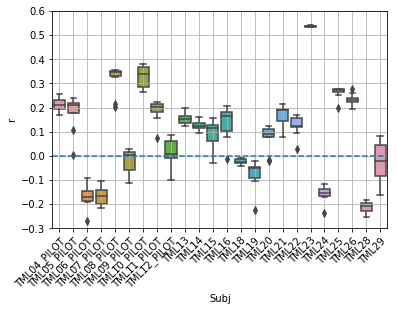

In [12]:
import seaborn as sns

ax = sns.boxplot(data=dp.loc[:,10:55].transpose())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0, ls='--')
ax.set(xlabel='Subj', ylabel='r', ylim=(-.3,.6))
ax.grid()

In [13]:
import re

nPCs = range(10,60,5)
dk = dpcr_whole_noscale
dp = pd.DataFrame(index=dk.index, columns=nPCs)

for idx in dp.index:
    for i, col in enumerate(nPCs):
        temp = re.findall('-0.\d+|0.\d+', dk.loc[idx,'rval'])
        dp.loc[idx,col] = temp[i]
dp

10           15           20           25           30  \
TML04_PILOT   0.28656552   0.27771111   0.30552681   0.33994926   0.29183229   
TML05_PILOT   -0.0269539     0.095193   0.16096714   0.17539405   0.20743716   
TML06_PILOT  -0.07367199  -0.08076885   -0.0916219  -0.02821037  -0.05601121   
TML07_PILOT  -0.15264299  -0.07812816  -0.08912629  -0.07146794  -0.10984798   
TML08_PILOT  -0.09456713  -0.01306298   0.10266259   0.08205715   0.08737071   
TML09_PILOT   0.06241931   0.03336168   0.01916046   0.02456761   0.02878788   
TML10_PILOT    0.1118458   0.14339169   0.22570131   0.19654375   0.28670193   
TML11_PILOT   0.01201093   0.08582535   0.15182107   0.10482256   0.07627738   
TML12_PILOT  -0.15665065  -0.19512961  -0.19706783  -0.13622784   -0.1064472   
TML13         -0.0877218   0.02319877   0.05475609   0.10231249   0.11240156   
TML14         0.07637175   0.03974848  -0.03628012  -0.00971628   -0.0256644   
TML15        -0.06066776  -0.09417944  -0.07300777  -0.10347097  -0.09608388   
TML16         -0.0191479   0.01118775   0.00446892   0.08840013   0.15092666   
TML18        -0.05285709   0.06995103   0.06059799   0.08696465   0.08891479   
TML19        -0.09357306   0.02513244   0.02568691   0.00350881   0.00748191   
TML20        -0.10704108  -0.00307376  -0.00054383   0.05523254     0.098567   
TML21        -0.07337052   0.02254787   0.05572585   0.08873495   0.11541685   
TML22        -0.04274934   0.03749086  -0.02040362   0.02002712   0.03363228   
TML23         0.55137671   0.56493391   0.56823728   0.59053001   0.58581647   
TML24        -0.23581208   -0.1375099  -0.11619893  -0.10906253  -0.14828342   
TML25         0.27713961   0.26931733   0.31550763   0.27440033   0.24962921   
TML26         0.07662297    0.1359749   0.12559267   0.11797979   0.12800596   
TML28        -0.21465912  -0.16456893  -0.19260944  -0.19132947  -0.24670433   
TML29        -0.10685836   -0.1191216  -0.13798603  -0.18514898  -0.18138681   

                      35           40           45           50           55  
TML04_PILOT   0.33763717   0.30354383   0.27124196   0.23245559   0.16440355  
TML05_PILOT   0.23562367   0.25237216   0.24954403   0.23810242   0.24129938  
TML06_PILOT  -0.00225487   -0.0173264  -0.02161753  -0.02032428  -0.01740036  
TML07_PILOT  -0.09796503  -0.10227732  -0.07239925  -0.06340161  -0.04922434  
TML08_PILOT   0.13810177   0.13318101   0.10993148   0.08256129   0.09532317  
TML09_PILOT   0.04659801    0.0629404   0.06884557    0.0427363   0.04170406  
TML10_PILOT   0.26162952   0.26926858   0.27520999   0.28175924   0.28008257  
TML11_PILOT   0.06670299    0.1032287   0.14136018   0.17237542   0.13687542  
TML12_PILOT   -0.1155954  -0.08079447  -0.05949462   -0.0299514  -0.05048475  
TML13         0.12230787   0.12795084   0.14500786   0.15322438   0.12583177  
TML14        -0.04713114  -0.03772141  -0.06397076  -0.05755959  -0.08797792  
TML15         -0.0464945  -0.07064159  -0.02645243   0.01021502   0.02061116  
TML16         0.13864694   0.11214219   0.13694754    0.1411236   0.19005147  
TML18         0.09697963   0.09697488   0.06962653   0.05262947   0.06175856  
TML19          0.0455335   0.02369171   0.00672289   0.06965563   0.06055335  
TML20         0.10646669   0.07737412   0.07825778    0.0693513    0.0877414  
TML21         0.09989159    0.1533351   0.14981906   0.16015191   0.18962542  
TML22         0.03867943   0.07976052   0.07662105   0.08580389   0.08608794  
TML23         0.58621333   0.58471213   0.59353603    0.6086745   0.61528762  
TML24        -0.13982844  -0.14389821   -0.1272341  -0.09860885    -0.105892  
TML25         0.30041668   0.30235852   0.27825507   0.28990734   0.30196416  
TML26         0.15212467   0.15882222   0.15636113   0.15311124   0.10443828  
TML28        -0.27418807   -0.2906821  -0.27660176  -0.27232534  -0.20835808  
TML29        -0.12491117  -0.12161097  -0.06619089  -0.01770565   0.02262834

[Text(0, 0.5, 'r'), Text(0.5, 0, 'nPCs')]

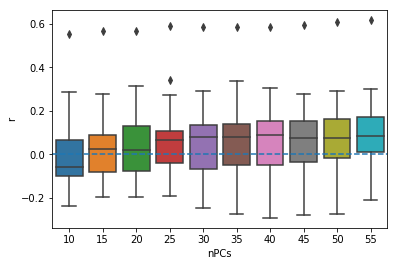

In [14]:
import seaborn as sns

ax = sns.boxplot(data=dp)
ax.axhline(0, ls='--')
ax.set(xlabel='nPCs', ylabel='r')

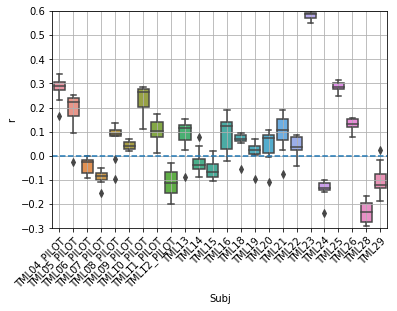

In [15]:
import seaborn as sns

ax = sns.boxplot(data=dp.loc[:,10:55].transpose())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0, ls='--')
ax.set(xlabel='Subj', ylabel='r', ylim=(-.3,.6))
ax.grid()

### mask

In [29]:
import re

nPCs = range(10,60,5)
dk = dpcr_tt11
dp = pd.DataFrame(index=dk.index, columns=nPCs)

for idx in dp.index:
    for i, col in enumerate(nPCs):
        temp = re.findall('-0.\d+|0.\d+', dk.loc[idx,'rval'])
        dp.loc[idx,col] = temp[i]
dp

10           15           20           25           30  \
TML04_PILOT   0.13911367   0.13450078   0.20256038   0.19731459   0.19993978   
TML05_PILOT   0.29613137   0.36268746   0.34936244   0.34785699    0.3743175   
TML06_PILOT  -0.28266263  -0.17722151  -0.16638199  -0.10163724  -0.11669127   
TML07_PILOT   -0.1110706  -0.15458725  -0.18798378  -0.16162216  -0.20208718   
TML08_PILOT   0.13841779   0.22871732   0.29014496   0.34006387   0.30765297   
TML09_PILOT  -0.09163246  -0.06499624  -0.01107172   0.04355306   0.04986616   
TML10_PILOT   0.23118037   0.20107912   0.25145397    0.2476757   0.19733653   
TML11_PILOT   0.15104956   0.20260197   0.20260566   0.22629067   0.22301772   
TML12_PILOT   0.26333047   0.24868406   0.23771218   0.24283611   0.26107791   
TML13        -0.01770039   0.06922987   0.10244244   0.13819313   0.14210887   
TML14         0.07608649   0.16127275   0.15985327   0.17123333   0.13383009   
TML15         0.11265914   0.28332955   0.29241777    0.3141007    0.3348786   
TML16          0.0203535   0.06130343   0.14524976    0.2096521   0.25873295   
TML18        -0.03055614   0.00319852   0.00916591  -0.00269536  -0.00158711   
TML19         0.04299773   0.14410687   0.23379931   0.24382329   0.25125947   
TML20         0.18640681   0.22021727   0.19997309   0.20639089   0.18802576   
TML21         0.07847358   0.14470403   0.14267812   0.13265502   0.15645453   
TML22         0.04136282   0.08224859   0.05807907   0.05880455   0.09552219   
TML23         0.49721252   0.47196951   0.51387572   0.51412804   0.50010942   
TML24         0.02907538   0.01490221   0.03832184    0.0458475  -0.04185025   
TML25         0.24783253   0.27141286   0.26212464   0.26272504   0.24003937   
TML26         0.22407288    0.2442566   0.24874678   0.26130583   0.21027872   
TML28        -0.20140781  -0.23669269  -0.25640732  -0.24654181  -0.24518556   
TML29        -0.15970137  -0.13122909  -0.08037262  -0.06751999   -0.0686017   

                      35           40           45           50           55  
TML04_PILOT   0.17133462    0.1471771   0.14418106   0.15576915   0.12165932  
TML05_PILOT   0.33607827   0.32209853   0.30238162   0.32681423   0.33316096  
TML06_PILOT  -0.11044173  -0.15069574  -0.11134395  -0.08449363   -0.0816788  
TML07_PILOT   -0.2022968  -0.20655286  -0.19406414  -0.20173657  -0.18340714  
TML08_PILOT    0.2939971   0.30774633    0.3039651   0.29389938   0.29269766  
TML09_PILOT   0.04223169   0.09200824   0.09674671   0.10702857   0.09646292  
TML10_PILOT   0.28168792   0.30283245   0.32199263   0.29569905   0.27320346  
TML11_PILOT   0.20199947   0.20846515   0.21474169   0.21412059   0.22382361  
TML12_PILOT   0.27097655    0.2711007   0.25105424   0.25303966   0.28128384  
TML13         0.15112047   0.10906845   0.09943322   0.10868203   0.08766297  
TML14         0.14355218   0.13203477   0.13360717   0.14275086   0.15461935  
TML15         0.32634363    0.3267958   0.30903257   0.33832126   0.34904226  
TML16         0.26501269    0.2855529    0.2812212    0.2684309   0.25965765  
TML18         0.01560723   0.00588326   0.01224852   0.01693979   0.02357702  
TML19         0.24630547   0.24999825   0.21573814   0.20978758   0.14081997  
TML20         0.20918261   0.19881115   0.19208321   0.18232569   0.17735924  
TML21         0.14186871   0.12982231   0.14934855   0.13940178   0.17404099  
TML22         0.06728172   0.09438782   0.12759327    0.1219395   0.11010041  
TML23         0.48727899   0.48728856   0.49118482   0.48656815   0.49259666  
TML24        -0.01226335  -0.03143437  -0.02690396  -0.02039117  -0.02622938  
TML25         0.24442385   0.20898573   0.22907134   0.20804066   0.21007188  
TML26         0.24880462   0.24236595    0.2374824   0.24970424   0.22103557  
TML28        -0.25604793  -0.26820921  -0.25398875  -0.21685539  -0.23610364  
TML29        -0.11353399  -0.02612197  -0.05765381  -0.05869761  -0.04267309

[Text(0, 0.5, 'r'), Text(0.5, 0, 'nPCs')]

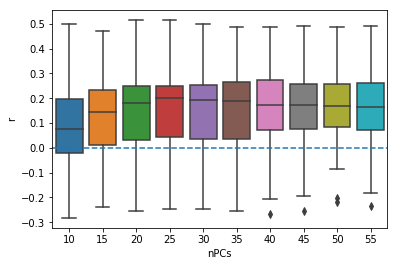

In [30]:
import seaborn as sns

ax = sns.boxplot(data=dp)
ax.axhline(0, ls='--')
ax.set(xlabel='nPCs', ylabel='r')

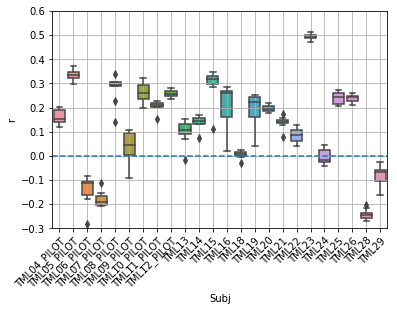

In [31]:
import seaborn as sns

ax = sns.boxplot(data=dp.loc[:,10:55].transpose())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0, ls='--')
ax.set(xlabel='Subj', ylabel='r', ylim=(-.3,.6))
ax.grid()

## Y_pred

In [44]:
subj = 'TML04_PILOT'
ys = [ load_2nd_target(subj, run) for run in [1,2,3] ]
ys = np.concatenate(ys)

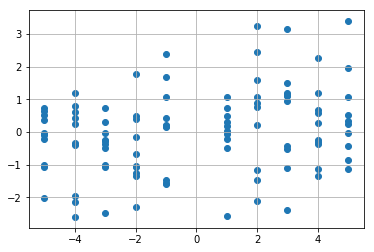

In [46]:
import re
import matplotlib.pyplot as plt

dk = dypred_whole
n_best = str(int(dpcr_whole.loc[subj,'nPCs_best']))

nPCs = dk.columns
dp = pd.DataFrame(index=range(100), columns=nPCs)

for col in nPCs:
    temp = np.float32(
        re.findall('\d+.\d+e-\d+|\d+.\d+e\+\d+|-\d+.\d+e-\d+|-\d+.\d+e\+\d+|-\d+.\d+|\d+.\d+', dk.loc[subj,col])
    )
    dp[col] = temp

plt.scatter(x=ys,y=dp[n_best])
plt.grid(True)

# Ensemble Method

In [141]:
from xgboost import plot_importance
from xgboost import XGB

ImportError: No module named 'xgboost'

# Junwoo Kang

In [17]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    #print(freqs)
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)
def KJW_get_dataframe(run):
    subj = 'KJW'
    df = pd.read_csv(behav_dir + subj + '/behav_data_Dis.dat', sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
    df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
    df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
    df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
    df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
    df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.rank'] = [a+b for a, b in zip(df['Freq.1.rank'], df['Freq.2.rank'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['F1<F2.rank'] = [b-a for a, b in zip(df['Freq.1'], df['Freq.2'])]
    
    temp = []
    trials = [20, 20, 20, 20, 20]
    fin = 0
    for x in trials:
        ini = fin
        fin = ini + x
        temp.append(df.loc[ini:fin-1])

    ## Note, Freq.other_answer.class == Freq.other_updown.class
    #validation = df['Freq.other_answer.class'] == df['Freq.other.classifier']
    #assert validation.all() == True
    #assert df['Freq.other_decision.class'].shape[0] == sum(trials)
    assert len(temp[run-1]) == trials[run-1]

    return temp[run-1]

def KJW_load_beta_image(run, nbetas=5, target_idx=2):
## load nilearn image ##
    subj = 'KJW'
    img = nilearn.image.load_img(stats_dir_6 + '%s/r%02d.LSSout.nii.gz' % (subj, run))
    ntrials = 20
    idx = np.array([ nbetas*i + target_idx for i in range(ntrials) ])
    temp = nilearn.image.index_img(img, idx)

    return temp

def KJW_load_target(run):
## load behavior data and make up them ##
    subj = 'KJW'
    df = KJW_get_dataframe(run)
    classifier = list(df['F1<F2.rank'])

    return classifier

### X: neural data / y: answers / group: run number
def KJW_get_X_y_group():
    subj = 'KJW'
    runs=[1,2,3,4,5]

    Xs = [ KJW_load_beta_image(run) for run in runs ]
    ys = [ KJW_load_target(run) for run in runs ]
    group = [ i for i, y in enumerate(ys) for j in range(len(y)) ]
    
    Xs = nilearn.image.concat_imgs(Xs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    return Xs, np.int32(ys), np.array(group)

from scipy import special
from scipy import optimize
def test_func(x, s):
    return 0.5*(1+special.erf(x/(np.sqrt(2)*s)))
def KJW_psychometric_x_y():
    subj = 'KJW'
    df = pd.concat([KJW_get_dataframe(1),KJW_get_dataframe(2),KJW_get_dataframe(3)
                   ,KJW_get_dataframe(4),KJW_get_dataframe(5)])
    a = df['Freq.other.rank']
    x = np.unique(df['Freq.other.rank'])
    c = df['Freq.other_decision.class'] # 'NaN' can be existed
    prob = [len(a[(c==1)&(a==x[i])])/len(a[a==x[i]]) for i in range(10)]
    return x, prob

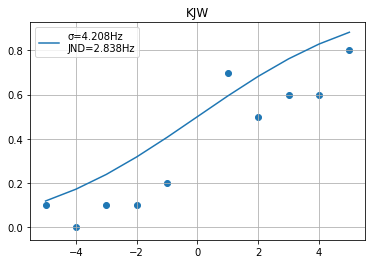

In [18]:
import matplotlib.pyplot as plt
subj = 'KJW'
t, prob = KJW_psychometric_x_y()
params, params_covariance = optimize.curve_fit(test_func, t, prob)
JND=special.erfinv(0.5)*(np.sqrt(2)*params[0]); # JND for 75%
plt.scatter(x=t,y=prob)
plt.plot(t, test_func(t, params[0]), label='\u03C3=%.3fHz\nJND=%.3fHz'%(params[0],JND))
plt.legend(loc='best')
plt.title(subj)
plt.grid()

In [27]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import scale
from PCRegression import PCR
import scipy.stats as stats
import matplotlib.pyplot as plt
from nilearn import plotting as nplt
from random import random as rand
from random import seed

def kjwPCR(path_roi, sigma):
    #np.set_printoptions(formatter={'float': '{: 0.5e}'.format})
    subj = 'KJW'
    Xs, ys, group = KJW_get_X_y_group()
    ys = 5*special.erf(ys/(np.sqrt(2)*sigma))

    ## whole brain
    #path_full = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
    ## Ttest mask
    #path_tt10 = stats_dir_10 + subj + '/Clust_mask_binary.nii.gz' 
    ## Ttest mask
    #path_tt11 = stats_dir_11 + subj + '/Clust_mask_binary.nii.gz'

    roi = nilearn.image.load_img(path_roi)
    
    temp = fast_masking(img=Xs, roi=roi)
    k = len(np.unique(group))
    cv = GroupKFold(k)
    nvoxels = temp.shape[0]
    #temp = mean_centering(temp)
    XT = temp.T
    print("%s's XT.shape ="%subj, XT.shape)
    
    nPCs = list(range(10,60,5))
    nPCs.append(None)
    #nPCs = [str(i) for i in nPCs]

    rval, pval = np.zeros(len(nPCs)), np.zeros(len(nPCs))
    ypred_opt = np.zeros(100)
    dg = pd.DataFrame(index=[subj], columns=nPCs)
    for i, n in enumerate(nPCs):
        ypred = np.zeros(100)
        for idx_train, idx_test in cv.split(XT, ys, group):
            g = int(np.unique(group[idx_test]))
            Xtrain = XT[idx_train,:]
            ytrain = ys[idx_train]
            #seed()
#             pcr = PCR(n_components = n_components,
#                       svd_solver='arpack',
#                       random_state=int(65536 * rand()))
            pcr = PCR(n_components = n)
            pcr.fit(Xtrain,ytrain)
            Xtest = XT[idx_test,:]
            ypred[idx_test] = pcr.predict(Xtest)
        rval[i], pval[i] = stats.pearsonr(ys,ypred)
        dg[n] = [ypred]
        if n==np.argmax(rval):
            ypred_opt = ypred
            
    idx_opt, rval_best = np.argmax(rval), np.max(rval)
    df = pd.DataFrame(
        {
            'nPCs_best':nPCs[idx_opt],
            'rval_best':rval_best,
            'nvoxels':nvoxels,
            'rval':[rval]
        },
        index=[subj]
    )
    colhead = ['nPCs_best','rval_best','nvoxels','rval']
    df = df.reindex(columns=colhead)
    
    return df, dg

def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)

    if img_data.shape[:3] != roi_mask.shape:
        if roi_mask.shape[-1] == 1:
            volume = roi_mask.shape[:3]
            roi_mask = roi_mask.reshape(volume)
        else:
            raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))

    return img_data[roi_mask,:]

In [28]:
subj = 'KJW'
path_full = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
df, dg = kjwPCR(path_roi=path_full, sigma=params[0])

KJW's XT.shape = (100, 269557)


In [29]:
df

nPCs_best  rval_best  nvoxels  \
KJW      None  -0.044839   269557   

                                                  rval  
KJW  [-0.14699485971865325, -0.11161447965005306, -...

In [30]:
dg

10  \
KJW  [1.2632303186404803, 0.8190198242326883, -0.63...   

                                                    15  \
KJW  [2.084121380078339, 0.750488079670686, -0.4379...   

                                                    20  \
KJW  [1.8120764994984182, 0.7810116701423497, -0.87...   

                                                    25  \
KJW  [2.0650846300160284, 0.6528673326719029, -0.76...   

                                                    30  \
KJW  [2.193501067640927, 0.5507210392260314, -0.671...   

                                                    35  \
KJW  [2.5261016536056125, 0.5510704812992877, -0.61...   

                                                    40  \
KJW  [2.6306383903380235, 0.6749842122953289, -0.46...   

                                                    45  \
KJW  [2.5147704396923345, 0.784713113490634, -0.740...   

                                                    50  \
KJW  [2.3143621758457984, 0.8142470410432177, -0.78...   

                                                    55  \
KJW  [2.5104920750244895, 0.8406875538900919, -0.81...   

                                                   NaN  
KJW  [2.344286248267668, 0.8195325037430017, -0.224...

In [31]:
Xs, ys, group = KJW_get_X_y_group()

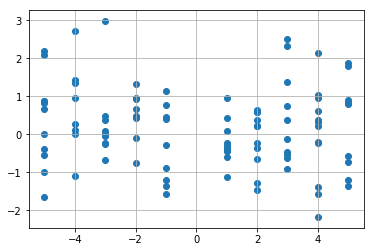

In [32]:
import re
import matplotlib.pyplot as plt

dk = dg
n_best = 45

nPCs = dk.columns
dp = pd.DataFrame(index=range(100), columns=nPCs)

for col in nPCs:
    dp[col] = dk.loc[subj,col]

plt.scatter(x=ys,y=dp[n_best])
plt.grid(True)

In [33]:
KJW_get_dataframe(1)

trial  Freq.1  ISI1  Freq.2  ISI2 decision  correctness     RT  ISI3  \
0   10001    15.0   7.5    18.0   4.5    after            1  0.416   7.5   
1   10002    16.0   8.5    15.0   3.5    after            0  0.472   8.5   
2   10003    17.0   5.5    15.0   6.5    after            0  0.320   5.5   
3   10004    12.0   8.5    15.0   3.5    after            1  0.441   8.5   
4   10005    10.0   8.5    15.0   3.5    after            1  0.562   8.5   
5   10006    15.0   3.5    13.0   8.5    after            0  0.339   3.5   
6   10007    20.0   7.5    15.0   4.5   before            1  0.655   7.5   
7   10008    19.0   4.5    15.0   7.5   before            1  0.386   4.5   
8   10009    15.0   5.5    11.0   6.5   before            1  1.015   5.5   
9   10010    15.0   3.5    14.0   8.5    after            0  0.468   3.5   
10  20001    15.0   4.5    14.0   7.5   before            1  0.465   4.5   
11  20002    15.0   5.5    13.0   6.5      NaN            0  2.000   5.5   
12  20003    18.0   5.5    15.0   6.5    after            0  0.571   5.5   
13  20004    15.0   4.5    10.0   7.5    after            0  0.664   4.5   
14  20005    15.0   6.5    16.0   5.5    after            1  0.569   6.5   
15  20006    15.0   8.5    19.0   3.5    after            1  0.455   8.5   
16  20007    20.0   6.5    15.0   5.5    after            0  0.521   6.5   
17  20008    12.0   3.5    15.0   8.5      NaN            0  2.000   3.5   
18  20009    17.0   6.5    15.0   5.5    after            0  0.676   6.5   
19  20010    11.0   7.5    15.0   4.5    after            1  0.787   7.5   

    Freq.1.class     ...      Freq.other.index  Freq.other.class  \
0              0     ...                     2                 1   
1              1     ...                     1                 1   
2              1     ...                     1                 1   
3             -1     ...                     1                -1   
4             -1     ...                     1                -1   
5              0     ...                     2                -1   
6              1     ...                     1                 1   
7              1     ...                     1                 1   
8              0     ...                     2                -1   
9              0     ...                     2                -1   
10             0     ...                     2                -1   
11             0     ...                     2                -1   
12             1     ...                     1                 1   
13             0     ...                     2                -1   
14             0     ...                     2                 1   
15             0     ...                     2                 1   
16             1     ...                     1                 1   
17            -1     ...                     1                -1   
18             1     ...                     1                 1   
19            -1     ...                     1                -1   

    answer.index  decision.index Freq.other_decision.class Freq.1.rank  \
0              2               2                         1           0   
1              1               2                        -1           1   
2              1               2                        -1           2   
3              2               2                        -1          -3   
4              2               2                        -1          -5   
5              1               2                         1           0   
6              1               1                         1           5   
7              1               1                         1           4   
8              1               1                        -1           0   
9              1               2                         1           0   
10             1               1                        -1           0   
11             1             NaN                       NaN           0   
12             1